<a href="https://colab.research.google.com/github/DmitryKudryashov/improvadostest/blob/master/1k_companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pickle 
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *


#Import second dataset



In [0]:
df = pd.read_excel('/content/Sample Data for Data Science Testing (1k companies).xlsx', header = 1)
df2 = df.drop([ 'January',
                'Febriary',
                'March',]
                ,axis = 1)

df2.rename(columns={"May '19":'1',
                    "Jun '19":'2',
                    "Jul '19":'3',
                    "Aug '19":'4',
                    "Sep '19":'5',
                    "Oct '19":'6',
                    "Nov '19":'7',
                    "Dec '19":'8',
                    "Jan '20":'9',
                    "Feb '20":'10',
                    "Mar '20":'11'}, 
                      inplace=True)

#Data preparation

In [148]:
melt = df2.melt(id_vars='Company', var_name='Month', value_name='Adspend') #create new dataset form

melt['Company'] = melt['Company'].str.extract('(\d+)', expand=False).astype(int)
melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Month', 'Company'])
melt.head()

,Company,Month,Adspend
0,1,1,142881.6
1,2,1,25612.8
2,3,1,13526.4
3,4,1,2316.9
4,5,1,107897.1


In [149]:
melt2 = melt.copy()                                   #copying and creating new variables 
melt2['lag1'] = melt2.groupby(['Company'])['Adspend'].shift()
melt2['diff'] = melt2.groupby(['Company'])['lag1'].diff()
melt2['lag2'] = melt2.groupby(['Company'])['Adspend'].shift(2)
melt2["Direction"] = np.sign(melt2['diff'])
melt2 = melt2.dropna()
melt2.head()

,Company,Month,Adspend,lag1,diff,lag2,Direction
2084,1,3,172.2,71213.1,-71668.5,142881.6,-1.0
2085,2,3,28436.7,28229.1,2616.3,25612.8,1.0
2086,3,3,247.2,151.8,-13374.6,13526.4,-1.0
2087,4,3,5480.7,5782.5,3465.6,2316.9,1.0
2088,5,3,1563.6,91683.3,-16213.8,107897.1,-1.0


#Spliting X and Y, preprocessing

In [0]:
x = melt2[['Company','Month','Adspend','lag1','lag2']]
y = melt2['Direction']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1)

In [0]:
d = pd.DataFrame(index=ytest.index) # data for testing
d["Actual"] = ytest
xtrain = xtrain[['lag1','lag2']]
xtest_fin = xtest.copy()
xtest = xtest[['lag1','lag2']]


# from sklearn import preprocessing                      #using for preprocessing
# scaler = preprocessing.StandardScaler().fit(xtrain)
# x_train = scaler.transform(xtrain)
# x_test = scaler.transform(xtest)

#Model training and testing + metrics report

In [152]:
# from sklearn.model_selection import GridSearchCV                        #using for searching best params
# clf = LogisticRegression()
# grid_values = {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],'max_iter':[300,450,500]}
# grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,cv=3)
# grid_clf_acc.fit(xtrain, ytrain)
# print('Best C: ', grid_clf_acc.best_estimator_.get_params()['C'])
# print('Best iter: ', grid_clf_acc.best_estimator_.get_params()['max_iter'])

model = LogisticRegression(C=5,max_iter=300)
model.fit(xtrain, ytrain)     # fitting model

d['Predict_LR'] = model.predict(xtest) # tests and creating actual+prediction dataset
fin_df = pd.concat([xtest_fin,d],axis = 1)

print('accuracy: ',accuracy_score(ytest, d['Predict_LR']))                   #metrics report
print('*********')
report = classification_report(ytest, d['Predict_LR'], target_names=['-1', '0','1'])
print(report)

accuracy:  0.9968017057569296
*********
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       336
           0       0.93      1.00      0.97        42
           1       1.00      1.00      1.00       560

    accuracy                           1.00       938
   macro avg       0.98      1.00      0.99       938
weighted avg       1.00      1.00      1.00       938



#Confusion matrix for labels



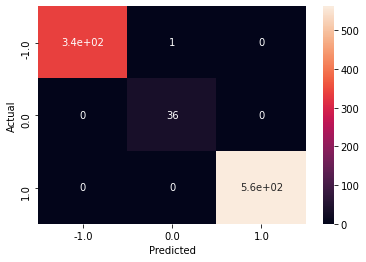

In [129]:
confusion_matrix = pd.crosstab(fin_df['Actual'], fin_df['Predict_LR'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

#Model saving

In [0]:

# Save the trained model as a pickle string. 
saved_model = pickle.dumps(model) 

# Load the pickled model 
model_from_pickle = pickle.loads(saved_model) 

# Use the loaded pickled model to make predictions 
#model_from_pickle.predict(xtest) 

#Example

In [154]:
fin_df[fin_df['Month']==11] #11 is actually adspends for last month 

,Company,Month,Adspend,lag1,lag2,Actual,Predict_LR
11392,973,11,17273.7,18148.5,18732.0,-1.0,-1.0
10460,41,11,194743.2,191493.9,192125.4,-1.0,-1.0
11130,711,11,117914.7,116449.2,111224.7,1.0,1.0
11051,632,11,2211728.1,2180647.5,2154043.5,1.0,1.0
10707,288,11,37795.2,36985.5,35222.1,1.0,1.0
...,...,...,...,...,...,...,...
10659,240,11,399685.2,356668.8,351627.9,1.0,1.0
11179,760,11,309533.1,310140.3,309619.2,1.0,1.0
10852,433,11,447049.8,399945.3,375409.5,1.0,1.0
10433,14,11,98356.2,93870.9,90393.0,1.0,1.0
